In [149]:
from conllu import parse

In [150]:
import pandas as pd
import numpy as np
import os

In [174]:
p = '../../prompts/rendered/merged_data.parquet'

df = pd.read_parquet(p).dropna(thresh=2)

In [175]:
# Replace None with ""
df = df.fillna(value="")

In [176]:
# Filter the ones without udpipe_result
df = df[df['udpipe_result'] != ""]

In [231]:
traits = ["raca","genero","regiao","localidade"]
traits

['raca', 'genero', 'regiao', 'localidade']

In [232]:
# replace "" to "empty"
for t in traits: 
    df[t] = df[t].replace("", "empty")

In [113]:
class LinguisticComplexityAnalyzer:
    def __init__(self):
        pass

    def count_func(self, sentence, func):
        return len([token for token in sentence if(func(token))])
    
    def profundidade_maxima(self, no):
        # Se nó não tem filhos, ele é folha
        if(not no.children):
            return 0
        
        filho_mais_fundo = max([self.profundidade_maxima(child) for child in no.children])
        return 1 + filho_mais_fundo
    
    def is_clause(self, token):
        for deprel in ["csubj", "ccomp", "xcomp", "advcl", "acl"]:
            if deprel in token["deprel"]:
                return True
        return False
    
    def is_dependent_clause(self, token):
        for deprel in ["advcl", "acl"]:
            if deprel in token["deprel"]:
                return True
        return False
    
    def is_Coordination(self, token):
        for deprel in ["conj", "cc"]:
            if deprel in token["deprel"]:
                return True
        return False
    
    def count_token(self, sentence):
        return len(sentence)
    
    def is_lexical_words(self, token):
        if token["upos"] in ["NOUN", "ADJ", "VERB"]:
            return True
        if "advmod" in token["deprel"]:
            return True
        return False

    def is_adjective(self, token):
        if token["upos"] == "ADJ":
            return True
        return False
    
    def is_substantive(self, token):
        if token["upos"] == "NOUN":
            return True
        return False
    
    def analyze_sentences(self, sentences):
        
        total_clauses = sum(self.count_func(sentence, self.is_clause) for sentence in sentences)
        total_dependent_clauses = sum(self.count_func(sentence, self.is_dependent_clause) for sentence in sentences)
        total_coordinated_phrases = sum(self.count_func(sentence, self.is_Coordination) for sentence in sentences)
        
        # Count total tokens and total sentences
        total_tokens = sum(self.count_token(sentence) for sentence in sentences)
        total_sentences = len(sentences)
        
        # Calculate average tree depth and maximum tree depth
        depths = [self.profundidade_maxima(sentence.to_tree()) for sentence in sentences]
        profundidade_media = np.mean(depths)
        profundidade_max = np.max(depths)
        
        # Calculate Type-Token Ratio (TTR)
        tokens = [token for sentence in sentences for token in sentence if token["upos"] != "PUNCT"]
        types = set(token["form"] for sentence in sentences for token in sentence)
        ttr = len(types) / len(tokens) if tokens else 0
        
        # Calculate lexical density (number of lexical words / total tokens)
        lexical_density = sum(self.count_func(sentence, self.is_lexical_words) for sentence in sentences) / total_tokens if total_tokens > 0 else 0
        
        # Calculate Measures of Linguistic Complexity (MLC) and Sentence Complexity (MLS)
        MLC = total_tokens / total_clauses if total_clauses > 0 else 0
        MLS = total_tokens / total_sentences if total_sentences > 0 else 0
        
        # Calculate Dependent Clauses per Clause (DCC) and Coordination per Clause (CPC)
        DCC = total_dependent_clauses / total_clauses if total_clauses > 0 else 0
        CPC = total_coordinated_phrases / total_clauses if total_clauses > 0 else 0

        # Counter the adjectives and substantives
        adjective_list = [token for sentence in sentences for token in sentence if self.is_adjective(token)]
        substantive_list = [token for sentence in sentences for token in sentence if self.is_substantive(token)]

        return {
            "MLC": MLC,
            "MLS": MLS,
            "DCC": DCC,
            "CPC": CPC,
            "profundidade_media": profundidade_media,
            "profundidade_max": profundidade_max,
            "ttr": ttr,
            "lexical_density": lexical_density,
            "token_quantity": total_tokens,
            "adjective_list": adjective_list,
            "substantive_list": substantive_list,
        }

In [114]:
# Parse the udpipe_result column and analyze linguistic complexity
analyzer = LinguisticComplexityAnalyzer()

def analyze_row(row):
    sentences = parse(row)
    return analyzer.analyze_sentences(sentences)

# df['analysis'] = df['udpipe_result'].apply(analyze_row)

In [180]:
len(df),len(analysis_df)

(23039, 23039)

In [183]:
from tqdm.notebook import tqdm

tqdm.pandas()

# Parse the udpipe_result column and analyze linguistic complexity with progress bar
df['analysis'] = df['udpipe_result'].progress_apply(analyze_row)

  0%|          | 0/23039 [00:00<?, ?it/s]

In [184]:
analysis_df = pd.json_normalize(df['analysis'])

In [198]:
df = pd.concat([df.reset_index(), analysis_df.reset_index()], axis=1)

In [199]:
df["adjective_list"][0][0]["form"]
# make the list of the forms
# Ensure that the column contains valid lists before applying the lambda function
df["adjective_list"] = df["adjective_list"].apply(lambda sentence: [word["form"] for word in sentence] if isinstance(sentence, list) else [])
df["substantive_list"] = df["substantive_list"].apply(lambda sentence: [word["form"] for word in sentence] if isinstance(sentence, list) else [])

## Quantitative

In [304]:
df.columns

Index(['index', 'messageId', 'original_prompt', 'model', 'response',
       'responseId', 'udpipe_result', 'genero', 'raca', 'regiao', 'localidade',
       'unused', 'artigo', 'pronome', 'analysis', 'index', 'MLC', 'MLS', 'DCC',
       'CPC', 'profundidade_media', 'profundidade_max', 'ttr',
       'lexical_density', 'token_quantity', 'adjective_list',
       'substantive_list'],
      dtype='object')

In [200]:
import seaborn as sns
import matplotlib.pyplot as plt

In [201]:
def remove_outliers(df, column):
    """
    Remove outliers from the DataFrame based on the IQR method.
    
    Parameters:
    df (DataFrame): The DataFrame from which to remove outliers.
    column (str): The column name for which to remove outliers.
    
    Returns:
    DataFrame: The DataFrame with outliers removed.
    """
    q1 = df[column].quantile(0.25)
    q3 = df[column].quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

In [298]:
from scipy.stats import tukey_hsd
def tukey(df,group,col):
    groups = df[group].unique()
    print(groups)
    # Make a list of values to each group
    groups_val = [df[df[group] == g][col].tolist() for g in groups]
    res = tukey_hsd(*groups_val)
    conf = res.confidence_interval(confidence_level=.99)
    print("\nSignificant differences (99% CI does not include 0):")
    for ((i, j), low) in np.ndenumerate(conf.low):
        if i == j:
            continue
        high = conf.high[i, j]
        if low > 0 or high < 0:
            print(f"({groups[i]} - {groups[j]}) [{low:.3f}, {high:.3f}]")

    print("\nEquivalent groups (99% CI includes 0):")
    for ((i, j), low) in np.ndenumerate(conf.low):
        if i == j:
            continue
        high = conf.high[i, j]
        if low <= 0 and high >= 0:
            print(f"({groups[i]} ≈ {groups[j]}) [{low:.3f}, {high:.3f}]")

def get_equivalent_groups(df, group_col, value_col, confidence_level=0.99):
    groups = df[group_col].unique()
    groups_val = [df[df[group_col] == g][value_col].tolist() for g in groups]
    res = tukey_hsd(*groups_val)
    conf = res.confidence_interval(confidence_level=.99)

    equivalent_pairs = []
    for ((i, j), low) in np.ndenumerate(conf.low):
        if i == j: continue
        g1, g2 = groups[i] , groups[j]
        if((g2,g1) in equivalent_pairs): continue
        low, high = conf.low[i, j], conf.high[i, j]
        if low <= 0 and high >= 0:
            equivalent_pairs.append((g1, g2))
    return equivalent_pairs

In [309]:
column = 'profundidade_media'
equivalent = get_equivalent_groups(df, 'raca', column)
equivalent

[('preta', 'parda'),
 ('preta', 'branca'),
 ('preta', 'indígena'),
 ('preta', 'empty'),
 ('parda', 'branca'),
 ('parda', 'indígena'),
 ('parda', 'empty'),
 ('branca', 'indígena'),
 ('branca', 'empty'),
 ('indígena', 'empty')]

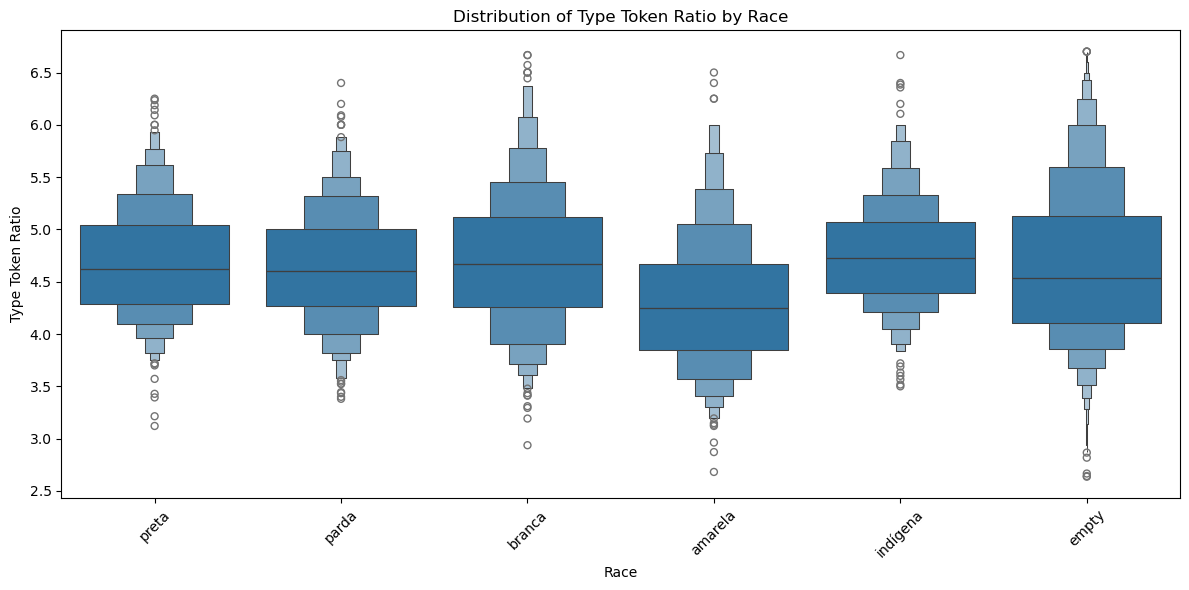

In [310]:

df_plot = remove_outliers(df, column)
plt.figure(figsize=(12, 6))
sns.boxenplot(x='raca', y=column, data=df_plot)
plt.title('Distribution of Type Token Ratio by Race')
plt.xlabel('Race')
plt.ylabel('Type Token Ratio')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [301]:
get_equivalent_groups(df_plot,"genero","ttr")

[('homem', 'não-binária'), ('homem', 'empty')]

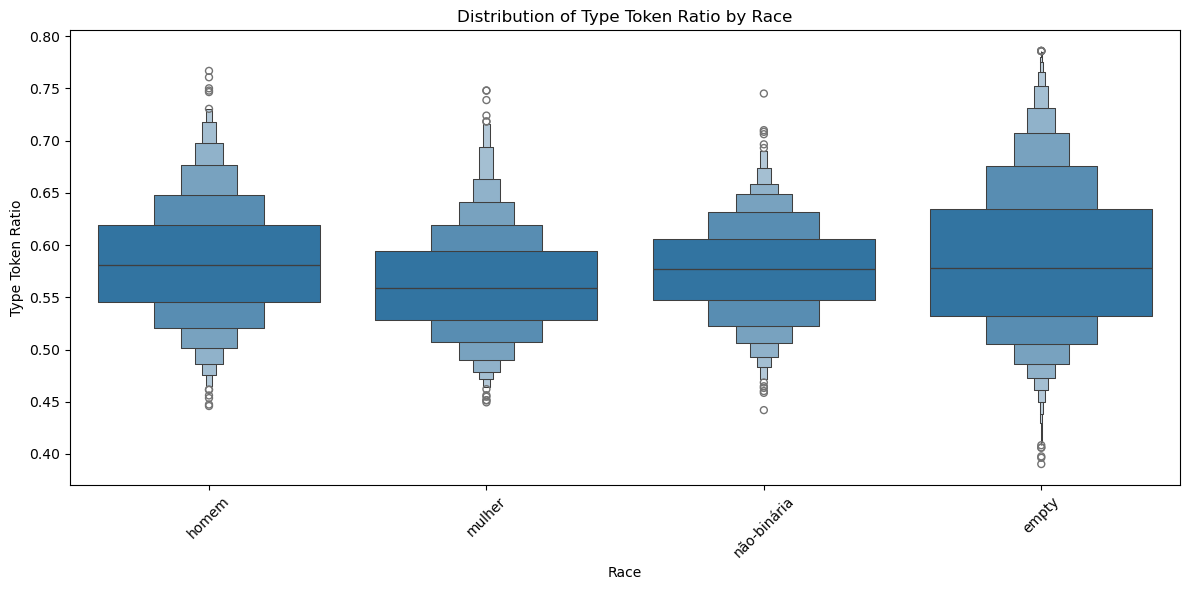

In [259]:
column = 'ttr'
df_plot = remove_outliers(df, column)
plt.figure(figsize=(12, 6))
sns.boxenplot(x='genero', y=column, data=df_plot)
plt.title('Distribution of Type Token Ratio by Race')
plt.xlabel('Race')
plt.ylabel('Type Token Ratio')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

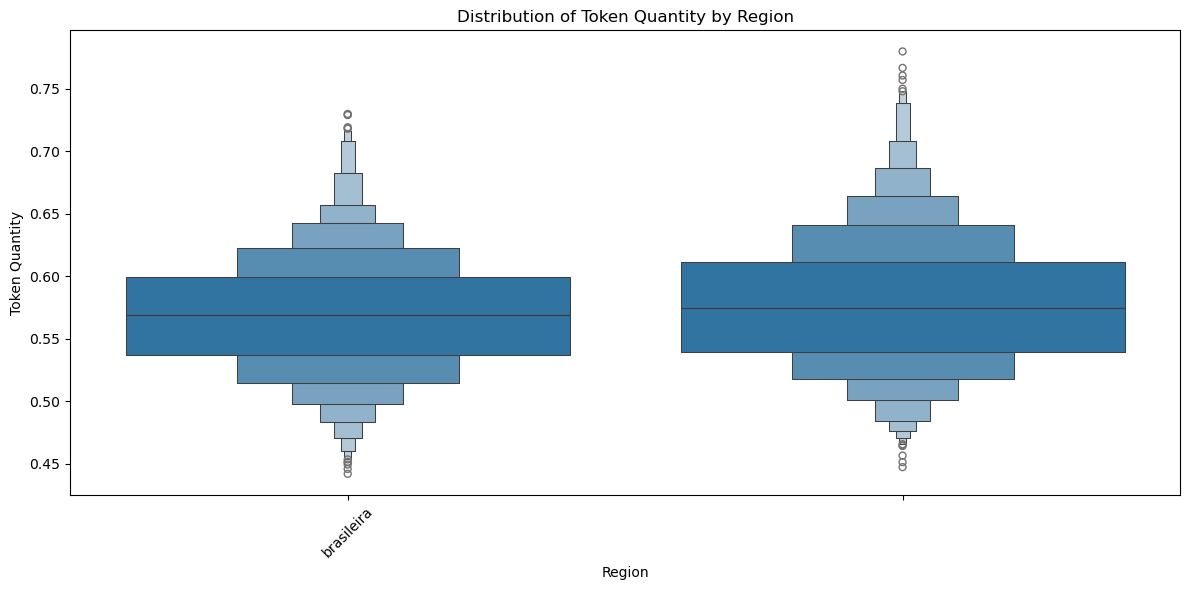

In [ ]:
column = 'ttr'
df_plot = remove_outliers(df, column)
plt.figure(figsize=(12, 6))
sns.boxenplot(x='localidade', y=column, data=df_plot)
plt.title('Distribution of Token Quantity by Region')
plt.xlabel('Region')
plt.ylabel('Token Quantity')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [ ]:
df = df.drop(["index","analysis"],axis=1)

In [323]:
df.to_parquet("merged.parquet",index=False)